In [3]:
import sys
sys.path.append('/home/wangs/rs/lib')
'''sys.path.append('/home/wangs/rs/lwm/lib')'''
import ff
import pandas as pd
import numpy as np
from multiprocessing import Pool
from tqdm import tqdm
import matplotlib as mpl
mpl.rc("font", family='Droid Sans Fallback', weight="bold")
import extend

In [4]:
import psutil
import os

print(u'当前进程的内存使用：%.4f GB' % (psutil.Process(os.getpid()).memory_info().rss / 1024 ** 3) )

info = psutil.virtual_memory()
print(u'电脑总内存：%.4f GB' % (info.total / 1024 ** 3) )
print(u'当前使用的总内存占比：',info.percent)
print(u'cpu个数：',psutil.cpu_count())

当前进程的内存使用：5.1343 GB
电脑总内存：1007.4503 GB
当前使用的总内存占比： 86.2
cpu个数： 256


# 个股成交额的市场跟随性与 “水中行舟”
因子一一多因子选股系列研究之

#  2、“水中行舟” 因子构建及测试

## 2.1 、“随波逐流” 因子
1) 对于股票 $\mathrm{A}$, 每天计算 $\mathrm{t}$ 日及过去 19 个交易日（ $\mathrm{t}-1 、 \mathrm{t}-2 、 \mathrm{t}-3 \cdots \cdots$. $\mathrm{t}-19$ 日) 的日内收益率（收盘价/开盘价-1）的均值。我们将这一收益率, 视为最近一段时间里个股 $\mathrm{A}$ 的合理日内收益率, 将其称为 $\mathrm{t}$ 日 “合理收益率”。
22) 对于股票 $\mathrm{A}$, 取其 1 分钟频率的数据, 剔除集合竞价数据, 计算每分钟的收盘价相对于这一天的开盘价的收益率（分钟 $\mathrm{i}$ 收盘价/当日开盘-1），得到每分钟的 “相对开盘收益率”
。3
3）在全天 240 个交易分钟里, 将那些 “相对开盘收益率” 大于当日 “合理收益率” 的分钟, 视为价格处于相对高位的时刻; 而那些 “相对开盘收益率” 小于当日 “合理收益率” 的分钟, 为价格处于相对低位的时
刻。
4）分别计算 $\mathrm{t}$ 日里, 价格处于相对高位的分钟成交额之和，记为 “高位成交额” ; 以及价格处于相对低位的分钟成交额之和, 记为 “低位成交
额”。
5）使用 $\mathrm{t}$ 日的 “高位成交额” 减去 $\mathrm{t}$ 日的 “低位成交额”, 日收盘时的流通市值, 得到股票 $\mathrm{A}$ 在 $\mathrm{t}$ 日在价格处于相对高位时的相对成交额，记为 “高低额差”。

6）每月月底，取所有股票过去 20 个交易日的 “高低额差” 序列。分别计算每只股票与其余所有股票的 “高低额差” 序列之间的 spearman 相关系数 (此处使用 spearman 相关系数, 是为了剔除 “高低额差” 指标本身大小的影响, 使其可以更好地刻画个股的 “高低额差” 在绝大多数时间里都与市场走势相关联, 而非某几天值较大导致的)
。
7）将上述的相关系数取绝对值, 相关系数的绝对值越大, 表明个股成交额与市场趋势之间的关联性越强; 而相关系数的绝对值越小, 表示个股成交额变化独立于市场趋势。最后, 计算股票 $\mathrm{A}$ 与其余股票的相关系数绝对值的均值, 记为股票 A 的“随波逐流” 因子。
根据前述的逻辑, 价格处于相对高位时, 相关系数越大的股票, 投资者对其价格的分歧度越小, 未来大概率表现较好。
下面我们在全 A 样本中按照月度频率对上述构建的 “随波逐流” 因子进行测试, 测试中对因子进行市值和行业正交化处理, 测试区间为 2013 年 1 月至 2023 年 1 月（下同）。再除以当

In [3]:
start, end = '20200102', '20240227'
start_time=pd.to_datetime(start)
end_time=pd.to_datetime('20240228')
read_data = lambda keyword:((ff.read(keyword) * ff.read('post') * ff.filter0).loc[:, start:end] 
                            if keyword in ('open', 'close', 'high', 'low')
                           else (ff.read(keyword) * ff.filter0).loc[:, start:end])

In [4]:
close,open,circ_mv,mv=read_data('close'),read_data('open'),read_data('circ_mv'),read_data("total_mv")
intraday_ret=close/open-1
codes=ff.cl
dates=list(pd.Series(index=ff.idt)[start:end].index)

In [8]:
def get_reasonable_ret(code):
    result={}
    data=intraday_ret.loc[code,:]
    result[code]=data.rolling(window=20,min_periods=20).mean()
    return result

In [9]:
with Pool(8) as p:
    res_lst_reasonable_ret = list(tqdm(p.imap(get_reasonable_ret, codes), total=len(codes)))
reasonable_ret=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_reasonable_ret}).T

100%|███████████████████████████████████████████████████████████████████████████████████████| 5279/5279 [00:02<00:00, 2609.59it/s]


In [11]:
reasonable_ret.columns=pd.to_datetime(reasonable_ret.columns)
def get_diff_vol(code):
    reasonable_ret_code=reasonable_ret.loc[code,:]
    try:
        data=ff.read_min(code)
        data.index=pd.to_datetime(data.index)
        data=data[start_time:end_time]#左闭右开
        if len(data)==0:
            pass
        else:
            open_data=data.groupby(data.index.date)['open'].first()
            data['open_ret']=(data['close']/open_data[data.index.date].values)-1
            data['h_l']=(data['open_ret']>reasonable_ret_code[data.index.date].values).replace({True:1,False:-1})
            mon_data=data.groupby(data.index.date).apply(lambda x:(x['h_l']*x['money']).sum())
            # index转换
            mon_data_date=mon_data.index
            mon_data.index=pd.to_datetime(mon_data_date).strftime('%Y%m%d')
            diff_vol=mon_data/circ_mv.loc[code,:]
            diff_vol.name=code
            return diff_vol
    except:
        pass

In [12]:
with Pool(8) as p:
    res_lst_diff_vol = list(tqdm(p.imap(get_diff_vol, codes), total=len(codes)))
diff_vol=pd.concat(res_lst_diff_vol,join='outer',axis=1).T

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5279/5279 [06:14<00:00, 14.11it/s]


In [14]:
def get_with_flow(date):
    result={}
    try:
        data=diff_vol.loc[:, :date].iloc[:, -20:]
        spearman_corr=abs((data.T).corr(method='spearman'))
        np.fill_diagonal(spearman_corr.values, np.nan)
        result[date]=spearman_corr.mean()
        return result
    except:
        result[date]=np.nan
        return result

In [15]:
with Pool(8) as p:
    res_lst_with_flow = list(tqdm(p.imap(get_with_flow, dates), total=len(dates)))
with_flow=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_with_flow})
with_flow.iloc[:,0:19]=np.nan

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [20:16<00:00,  1.21s/it]


In [43]:
with_flow_new.iloc[:,-20:]

,20240123,20240124,20240125,20240126,20240129,20240130,20240131,20240201,20240202,20240205,20240206,20240207,20240208,20240219,20240220,20240221,20240222,20240223,20240226,20240227
000001.SZ,-0.036651,-0.038143,-0.020915,-0.041360,-0.049828,-0.030304,-0.037521,-0.045303,-0.016991,-0.104072,-0.064715,-0.086601,-0.128268,-0.136815,-0.136496,-0.119050,-0.088469,-0.122489,-0.113066,-0.091932
000002.SZ,0.034683,0.024668,0.037340,0.016166,0.006733,0.021575,0.016872,0.039587,0.044409,0.050771,0.095179,0.088471,0.110054,0.022930,0.004781,0.032998,-0.020107,-0.030517,-0.062953,-0.054932
000004.SZ,-0.078772,-0.085541,-0.077273,-0.048511,-0.055776,-0.074805,-0.062718,-0.039308,-0.016746,-0.002877,-0.028586,-0.050936,-0.051139,0.008610,0.021553,0.030238,0.029976,0.024721,0.032766,0.027295
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,-0.088295,-0.077499,-0.081574,-0.021835,-0.109671,-0.087609,-0.073799,-0.076498,-0.085542,-0.093405,-0.076625,-0.070315,-0.087408,-0.112019,-0.113593,-0.145680,-0.160420,-0.187703,-0.185814,-0.169577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,-0.098736,-0.124313,-0.119549,-0.053539,-0.074812,-0.033011,-0.018289,-0.013093,-0.008283,0.010472,0.028252,0.035495,0.052776,0.031555,0.035813,0.060795,0.077238,0.072099,0.068199,0.059263
688800.SH,-0.029556,-0.028665,-0.002829,-0.025451,-0.035201,-0.044031,-0.039310,-0.034783,-0.048031,-0.042412,0.010910,0.011629,0.018620,0.029861,0.038473,0.062060,0.061226,0.082613,0.059967,0.041026
688819.SH,-0.003432,-0.001394,0.013716,-0.004033,-0.011629,-0.008116,-0.035223,-0.033076,-0.018899,-0.032502,-0.036495,-0.012444,-0.022190,-0.044787,-0.049723,-0.066241,-0.109995,-0.112978,-0.111629,-0.091849
688981.SH,-0.052846,-0.048624,-0.031945,-0.034628,-0.019659,-0.037659,-0.053376,-0.054357,-0.051871,-0.090879,-0.015378,-0.059378,-0.043259,-0.015519,-0.055732,-0.006903,-0.042969,-0.097567,-0.075416,-0.020848


In [17]:
with_flow_new = extend.spread_reg(with_flow,mv.loc[:,dates],ind=True) 

long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


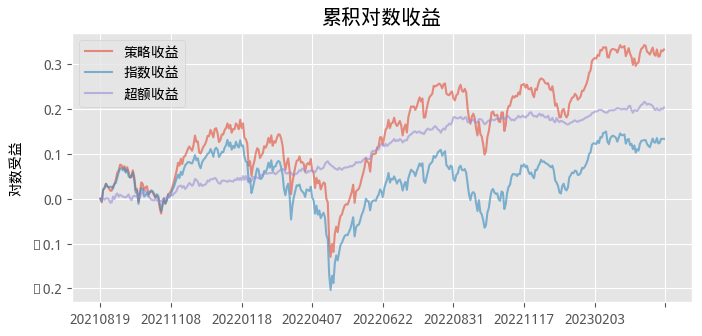

,指数收益,超额收益,策略收益
年化收益率,0.083,0.127,0.208
年化波动率,0.212,0.061,0.231
夏普率,0.394,2.069,0.898
最大回撤,-0.335,-0.027,-0.306
收益回撤比,0.249,4.690,0.680
胜率,0.555,0.550,0.580
盈亏比,0.853,1.136,0.837


In [19]:
h = ff.run(-with_flow_new.loc[:,'20210819':'20230414'], positions = 100, period = 1, fees = 0) 

## 2.2 “孤雁出群” 因子
1) 对于交易日 $\mathrm{t}$, 计算每只股票的分钟收益率 (t 分钟收盘价/t-1 分钟收盘价-1）。
   
2) 计算每一分钟所有股票的分钟收益率的标准差, 作为这一分钟个股收益分化程度的指标, 记为 “分钟市场分化度”。
   
3）计算这一天所有 “分钟市场分化度” 的均值, 找到那些 “分钟市场分化度”小于均值的时刻, 记为 $\mathrm{t}$ 日的 “不分化时刻”
。
4）取市场上所有股票在当日 “不分化时刻” 的成交额序列, 然后分别计算每只股票的分钟成交额序列与其余股票分钟成交额序列的 pearson 相关系数 (此处使用 pearson 相关系数, 是因为大部分股票在一天的交易时间里，大部分的时间交易并不活跃，特别是当市场相对清淡时, 因此大部分的信息可能隐藏在少数的分钟里, 因此这里我们不再使用 spearman 相关系数, 而改为使用 pearson 相关系数, 希望提高那些交易活跃的分钟在因子计算中的重要性及其所占的比重
）。
5) 将上述的相关系数取绝对值, 然后分别计算每只股票与其余股票的相关系数绝对值的均值, 记为 “日孤雁出群” 因子, 作为这只股票在市场分化不明显时, 其交易额与市场趋势的关联性的代理变量。根据前述罗辑, “日孤雁出群” 因子越小, 表示在市场清淡缺乏热点的情况下, 该个股的成交额走出了独立趋势, 很可能预示着新的热点正在
   孕育。
6）每月月底, 分别计算过去 20 个交易日 “日孤雁出群” 因子的均值和标准差, 得到 “月均孤雁出群” 因子和 “月稳孤雁出群” 因子, 并将二者等权合成, 得到“孤雁出群”因子。
   

In [5]:
day_data_close = pd.read_pickle('/mydata2/wangs/data/fmins/close.pk')
day_data_close.index=pd.to_datetime(day_data_close.index)
day_data_close=day_data_close[start_time:end_time]
min_ret=day_data_close.groupby(day_data_close.index.date).apply(lambda x:(x-x.shift(1))/x.shift(1))

In [6]:
min_diff=min_ret.std(axis=1)

In [7]:
mean_min_diff=min_diff.groupby(min_diff.index.date).mean()
mean_min_diff.index=pd.to_datetime(mean_min_diff.index)

In [8]:
non_diff_min=min_diff[min_diff<mean_min_diff[min_diff.index.date].values].index

In [9]:
def get_date_money(code):
    try:
        data=ff.read_min(code)['money']
        data.index=pd.to_datetime(data.index)
        data=data[start_time:end_time]
        if len(data)!=0:
            data.name=code
            return data
        else:
            pass
    except:
        pass

In [10]:
with Pool(8) as p:
    res_lst_date_money = list(tqdm(p.imap(get_date_money, codes), total=len(codes)))
date_money=pd.concat(res_lst_date_money,join='outer',axis=1).T

100%|█████████████████████████████████████████████████████████████████████████████████████████| 5279/5279 [02:30<00:00, 35.19it/s]


In [11]:
def get_non_diff_min_new(date):
    date_time=pd.to_datetime(date)
    date_min=non_diff_min[non_diff_min.date==date_time]
    return date_min
with Pool(8) as p:
    res_lst_non_diff_min_new = list(tqdm(p.imap(get_non_diff_min_new, dates), total=len(dates)))
non_diff_min_new=pd.Series(res_lst_non_diff_min_new,index=dates)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [01:59<00:00,  8.38it/s]


In [12]:
# 减小计算量,数据预处理
def get_date_money_new(date):
    date_time=pd.to_datetime(date)
    data=(date_money.loc[:,date_money.columns.date==date_time]).dropna(how='all',axis=0)
    return data
with Pool(8) as p:
    res_lst_date_money_new = list(tqdm(p.imap(get_date_money_new, dates), total=len(dates)))
date_money_new=pd.Series(res_lst_date_money_new,index=dates)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [02:55<00:00,  5.72it/s]


In [13]:
def get_out_flock(date):
    result={}
    date_min=non_diff_min_new[date]
    pearson_corr=abs(((date_money_new[date].loc[:,date_min]).T).corr(method='pearson'))
    np.fill_diagonal(pearson_corr.values, np.nan)    
    result[date]=pearson_corr.mean()
    return result     

In [14]:
with Pool(8) as p:
    res_lst_out_flock = list(tqdm(p.imap(get_out_flock, dates), total=len(dates)))
out_flock=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in res_lst_out_flock})

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [13:26<00:00,  1.25it/s]


In [15]:
def get_factor_out_flock(code):
    result={}
    # 有的code不在index中
    try:
        data=out_flock.loc[code,:]
        result[code]=(data.rolling(window=20,min_periods=20).mean()+data.rolling(window=20,min_periods=20).std())*0.5
        return result
    except:
        pass

In [16]:
with Pool(8) as p:
    res_lst_factor_out_flock = list(tqdm(p.imap(get_factor_out_flock, codes), total=len(codes)))
cleaned_res_lst_factor_out_flock = [x for x in res_lst_factor_out_flock if x is not None]
factor_out_flock=pd.DataFrame({list(i.keys())[0]: list(i.values())[0] for i in cleaned_res_lst_factor_out_flock}).T
factor_out_flock.iloc[:,0:19]=np.nan

100%|███████████████████████████████████████████████████████████████████████████████████████| 5279/5279 [00:02<00:00, 2475.72it/s]


In [17]:
factor_out_flock_new = extend.spread_reg(factor_out_flock,mv.loc[:,dates],ind=True) 

In [23]:
dates

['20200102',
 '20200103',
 '20200106',
 '20200107',
 '20200108',
 '20200109',
 '20200110',
 '20200113',
 '20200114',
 '20200115',
 '20200116',
 '20200117',
 '20200120',
 '20200121',
 '20200122',
 '20200123',
 '20200203',
 '20200204',
 '20200205',
 '20200206',
 '20200207',
 '20200210',
 '20200211',
 '20200212',
 '20200213',
 '20200214',
 '20200217',
 '20200218',
 '20200219',
 '20200220',
 '20200221',
 '20200224',
 '20200225',
 '20200226',
 '20200227',
 '20200228',
 '20200302',
 '20200303',
 '20200304',
 '20200305',
 '20200306',
 '20200309',
 '20200310',
 '20200311',
 '20200312',
 '20200313',
 '20200316',
 '20200317',
 '20200318',
 '20200319',
 '20200320',
 '20200323',
 '20200324',
 '20200325',
 '20200326',
 '20200327',
 '20200330',
 '20200331',
 '20200401',
 '20200402',
 '20200403',
 '20200407',
 '20200408',
 '20200409',
 '20200410',
 '20200413',
 '20200414',
 '20200415',
 '20200416',
 '20200417',
 '20200420',
 '20200421',
 '20200422',
 '20200423',
 '20200424',
 '20200427',
 '20200428',

In [22]:
mv.loc[:,'20210818':]

,20210818,20210819,20210820,20210823,20210824,20210825,20210826,20210827,20210830,20210831,...,20240206,20240207,20240208,20240219,20240220,20240221,20240222,20240223,20240226,20240227
000001.SZ,4.001500e+07,3.947164e+07,3.768629e+07,3.745342e+07,3.756986e+07,3.718174e+07,3.582332e+07,3.568748e+07,3.438729e+07,3.454253e+07,...,1.878493e+07,1.864909e+07,1.876552e+07,1.903721e+07,1.905661e+07,2.095839e+07,2.115245e+07,2.105542e+07,2.043443e+07,2.037621e+07
000002.SZ,2.755726e+07,2.689505e+07,2.643034e+07,2.651166e+07,2.674402e+07,2.469231e+07,2.426218e+07,2.429705e+07,2.258812e+07,2.301826e+07,...,1.134610e+07,1.135804e+07,1.200229e+07,1.173982e+07,1.181140e+07,1.218125e+07,1.210967e+07,1.216932e+07,1.190685e+07,1.200229e+07
000004.SZ,3.316624e+05,3.288544e+05,3.082620e+05,3.154381e+05,3.134101e+05,3.091980e+05,3.015538e+05,3.113820e+05,3.138781e+05,3.003058e+05,...,1.224518e+05,1.207308e+05,1.274822e+05,1.376755e+05,1.396612e+05,1.427059e+05,1.491926e+05,1.579297e+05,1.632249e+05,1.795077e+05
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,6.236977e+05,6.155977e+05,6.169477e+05,6.236977e+05,6.250477e+05,6.263977e+05,6.304477e+05,6.142477e+05,6.074978e+05,6.115478e+05,...,5.021982e+05,5.102981e+05,5.467480e+05,5.386480e+05,5.399980e+05,5.453980e+05,5.440480e+05,5.494480e+05,5.440480e+05,5.575480e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873703.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873726.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873806.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
873833.BJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
factor_out_flock.iloc[:,-20:]

,20240123,20240124,20240125,20240126,20240129,20240130,20240131,20240201,20240202,20240205,20240206,20240207,20240208,20240219,20240220,20240221,20240222,20240223,20240226,20240227
000001.SZ,0.078987,0.080938,0.080848,0.080391,0.076651,0.086797,0.090268,0.090930,0.092109,0.092209,0.092293,0.092403,0.097853,0.097999,0.099394,0.099456,0.097633,0.098073,0.096368,0.110197
000002.SZ,0.077856,0.079313,0.079319,0.079754,0.079887,0.085304,0.091795,0.092704,0.092884,0.096570,0.097552,0.098496,0.103304,0.104084,0.105311,0.105158,0.109348,0.111123,0.110385,0.111702
000004.SZ,0.085735,0.086694,0.086016,0.083414,0.082829,0.082329,0.080776,0.081986,0.082585,0.082413,0.083392,0.084377,0.076113,0.082673,0.084042,0.084603,0.085355,0.083509,0.087700,0.087544
000005.SZ,0.045464,0.043434,0.044201,0.044181,0.044461,0.045395,0.045972,0.045973,0.045868,0.045865,0.045843,0.045836,0.041673,0.042107,0.042070,0.042028,0.042966,0.042944,0.040826,0.039453
000006.SZ,0.065192,0.065162,0.065529,0.063929,0.063266,0.063019,0.066460,0.068345,0.069649,0.079730,0.081631,0.081204,0.083873,0.085265,0.088150,0.088567,0.090483,0.093246,0.093517,0.094111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601558.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603157.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603996.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
688086.SH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
factor_out_flock_new.iloc[:,-20:]

,20240123,20240124,20240125,20240126,20240129,20240130,20240131,20240201,20240202,20240205,20240206,20240207,20240208,20240219,20240220,20240221,20240222,20240223,20240226,20240227
000001.SZ,0.020133,0.021454,0.021337,0.020306,0.016767,0.023224,0.025198,0.025683,0.026149,0.022410,0.021359,0.021385,0.023022,0.022733,0.023655,0.023382,0.021180,0.021415,0.019926,0.032116
000002.SZ,0.016049,0.017057,0.017036,0.017220,0.017687,0.019859,0.024254,0.024586,0.024501,0.025015,0.024912,0.025505,0.029058,0.029092,0.028855,0.028336,0.029704,0.029605,0.028979,0.028545
000004.SZ,0.010392,0.010638,0.009623,0.007082,0.006529,0.002582,-0.000832,0.000013,0.000349,-0.003555,-0.003472,-0.002709,-0.009863,-0.004887,-0.005177,-0.005427,-0.007689,-0.010898,-0.007110,-0.009260
000005.SZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000006.SZ,0.004569,0.004115,0.004491,0.002708,0.002288,-0.001115,0.000142,0.001453,0.002415,0.009131,0.010125,0.009352,0.011214,0.011668,0.013147,0.013240,0.012238,0.013113,0.013457,0.012470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688799.SH,-0.004658,-0.005424,-0.005627,-0.007550,-0.007501,-0.003853,-0.001941,-0.002420,-0.002917,-0.008643,-0.009480,-0.008029,-0.009048,-0.010110,-0.011626,-0.012316,-0.017765,-0.019324,-0.019713,-0.018935
688800.SH,0.001024,-0.000625,0.001208,0.001179,-0.001884,-0.002427,-0.003344,-0.003617,-0.003322,-0.006074,-0.006754,-0.006659,-0.014916,-0.016699,-0.018660,-0.019621,-0.021607,-0.023721,-0.026420,-0.028238
688819.SH,0.000378,-0.000114,0.000052,-0.001042,-0.000942,0.005004,0.004286,0.003860,0.003396,-0.001142,-0.001604,-0.001551,-0.000713,-0.002187,-0.002074,-0.002531,-0.003444,-0.001445,-0.002168,-0.004555
688981.SH,0.004441,0.003197,0.002816,0.006976,0.007292,0.007785,0.005422,0.006720,0.007278,0.004191,0.003437,0.003750,0.011002,0.014223,0.019176,0.019016,0.023209,0.028745,0.028413,0.025817


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


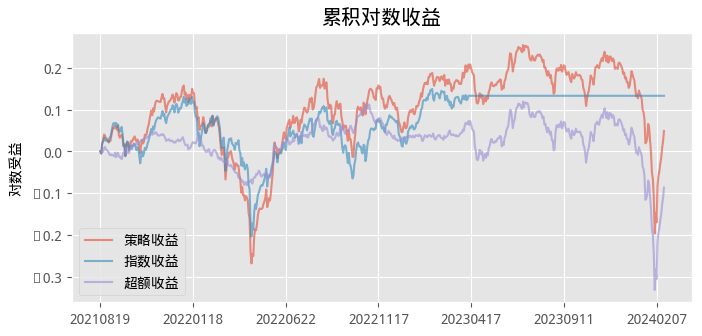

,指数收益,超额收益,策略收益
年化收益率,0.055,-0.036,0.020
年化波动率,0.171,0.169,0.237
夏普率,0.319,-0.211,0.085
最大回撤,-0.335,-0.451,-0.451
收益回撤比,0.163,-0.079,0.045
胜率,0.365,0.483,0.525
盈亏比,1.860,1.024,0.913


In [25]:
h = ff.run((factor_out_flock_new*ff.filter0).loc[:,'20210819':'20240227'], positions = 100, period = 1, fees = 0) 

## 2.3、“水中行舟” 因子 

In [34]:
boat_water=(factor_out_flock-with_flow)/2

In [35]:
boat_water_new = extend.spread_reg(boat_water,mv.loc[:,dates],ind=True) 

In [36]:
boat_water_new_c=(factor_out_flock_new-with_flow_new)/2

In [4]:
ff.perf.all_market

,ret,close,pre,做空收益
20110107,-0.004205,0.991902,0.996090,0.004196
20110110,-0.025353,0.966754,0.991902,0.025037
20110111,-0.005883,0.961066,0.966754,0.005866
20110112,0.006638,0.967446,0.961066,-0.006661
20110113,-0.000650,0.966817,0.967446,0.000650
...,...,...,...,...
20230406,-0.000506,3.112554,3.114130,0.000506
20230407,0.010215,3.144349,3.112554,-0.010268
20230410,-0.012117,3.106251,3.144349,0.012044
20230411,0.001772,3.111754,3.106251,-0.001773


long normal
持仓模式： 普通模式
持仓周期： 1
仓位数：   100
排序:      正序
回测部分：
回测仓位数： 100
回测手续费： 0
交易模式： t日收盘价买入，收盘价卖出


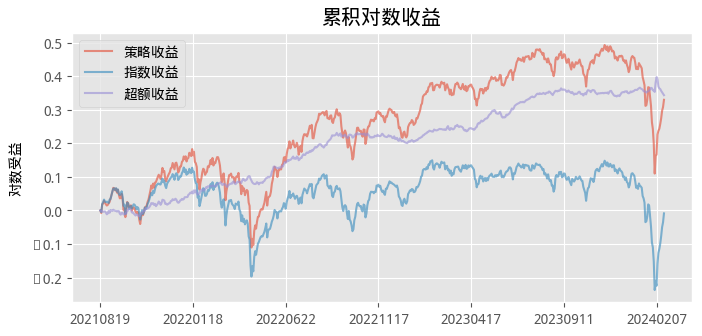

,指数收益,超额收益,策略收益
年化收益率,-0.004,0.141,0.136
年化波动率,0.215,0.061,0.233
夏普率,-0.016,2.313,0.582
最大回撤,-0.387,-0.054,-0.383
收益回撤比,-0.009,2.623,0.354
胜率,0.535,0.557,0.565
盈亏比,0.863,1.170,0.849


In [5]:
boat_water_new = ff.read('boat_water_RC')
h = ff.run((boat_water_new*ff.filter0).loc[:,'20210819':'20240227'], positions = 100, period = 1, fees = 0) 